# Convolutional Autoencoder for Image Denoising

### 1. Encoder

The encoder uses **Conv2d layers** to extract features from the input image. Each convolution:

- Slides a learnable filter (kernel) over the image.
- Produces multiple **feature maps** (channels) representing patterns.
- Reduces the **spatial dimensions** (height & width) depending on `stride` and `padding`.

**Output size formula** for each dimension (H or W):

Output = floor((Input + 2*padding - kernel_size) / stride) + 1

Example: nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)

- Input: 3×32×32  
- Output: 32×16×16  

The encoder compresses the image into a **latent feature map**.


### 2. Decoder

The decoder uses **ConvTranspose2d layers** (transposed convolution) to **upsample** latent features back to the original image size. It performs the inverse of convolution:

- Increases spatial dimensions (H×W).
- Reduces channels to match the original image (3 for RGB).
- Produces the reconstructed output image.


### 3. Non-linearity

- `ReLU()` is applied after each conv layer for non-linearity.
- `Sigmoid()` is applied at the final output to normalize pixel values to [0,1].


### 4. Loss and Optimization

- **Mean Squared Error (MSE)** between reconstructed and original image:
- Optimized using **Adam** optimizer to update convolutional filters.

100%|██████████| 170498071/170498071 [14:57<00:00, 189963.76it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/50] Loss: 0.0135
Epoch [2/50] Loss: 0.0070
Epoch [3/50] Loss: 0.0062
Epoch [4/50] Loss: 0.0055
Epoch [5/50] Loss: 0.0051
Epoch [6/50] Loss: 0.0049
Epoch [7/50] Loss: 0.0048
Epoch [8/50] Loss: 0.0047
Epoch [9/50] Loss: 0.0046
Epoch [10/50] Loss: 0.0045
Epoch [11/50] Loss: 0.0045
Epoch [12/50] Loss: 0.0044
Epoch [13/50] Loss: 0.0044
Epoch [14/50] Loss: 0.0044
Epoch [15/50] Loss: 0.0043
Epoch [16/50] Loss: 0.0043
Epoch [17/50] Loss: 0.0042
Epoch [18/50] Loss: 0.0042
Epoch [19/50] Loss: 0.0042
Epoch [20/50] Loss: 0.0042
Epoch [21/50] Loss: 0.0041
Epoch [22/50] Loss: 0.0041
Epoch [23/50] Loss: 0.0041
Epoch [24/50] Loss: 0.0041
Epoch [25/50] Loss: 0.0041
Epoch [26/50] Loss: 0.0041
Epoch [27/50] Loss: 0.0040
Epoch [28/50] Loss: 0.0040
Epoch [29/50] Loss: 0.0040
Epoch [30/50] Loss: 0.0040
Epoch [31/50] Loss: 0.0040
Epoch [32/50] Loss: 0.0040
Epoch [33/50] Loss: 0.0040
Epoch [34/50] Loss: 0.0040
Ep

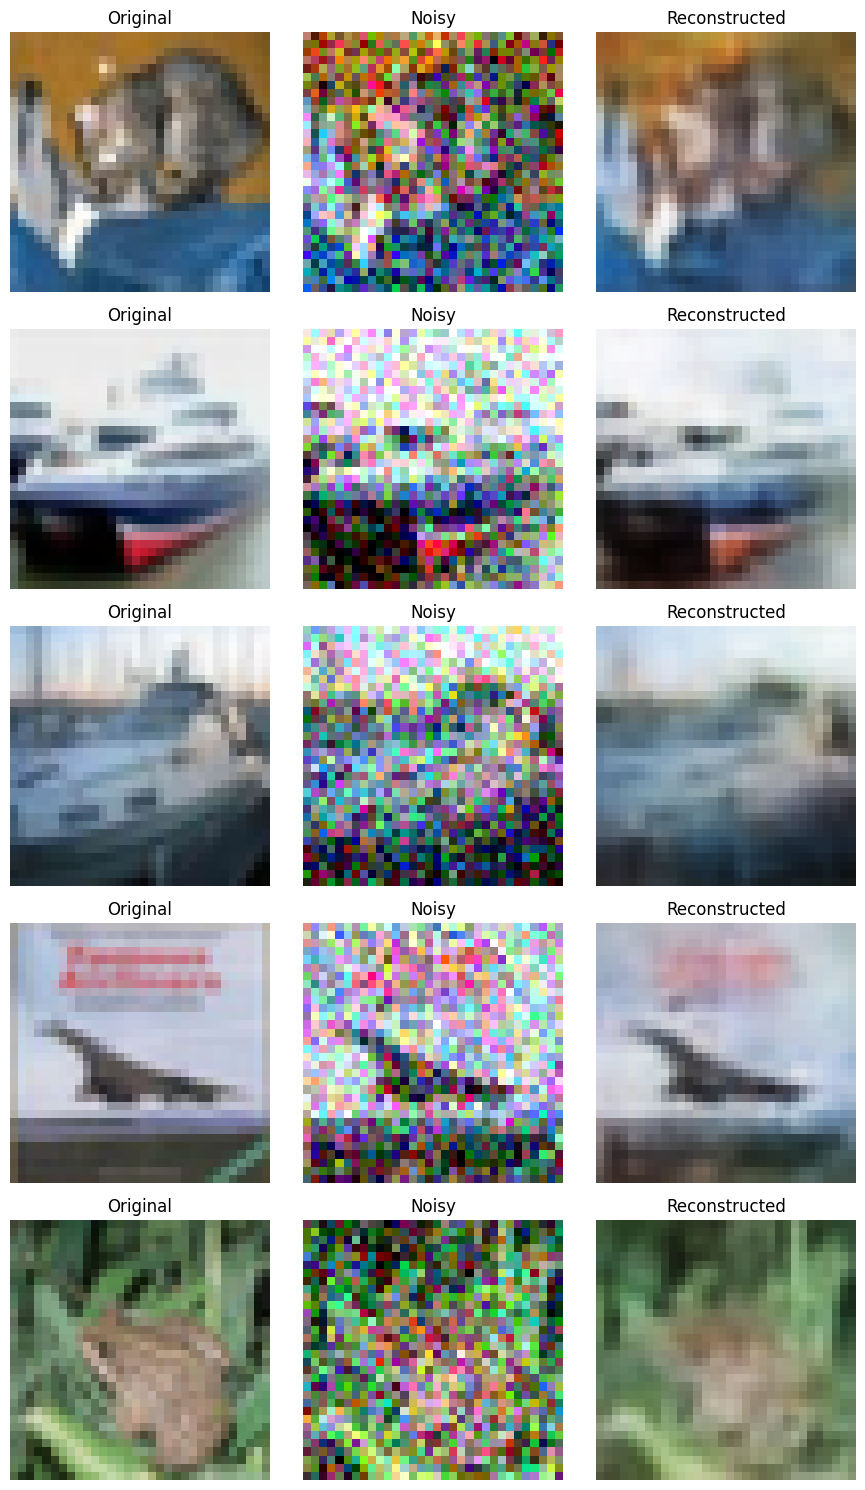

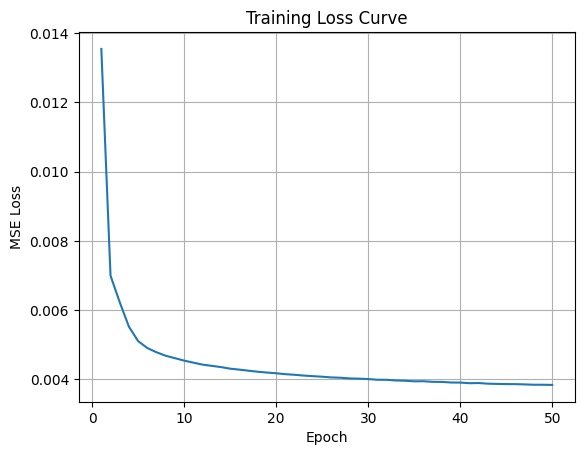

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np


batch_size = 64
epochs = 50
lr = 1e-3
noise_std = 0.2  # Gaussian noise standard deviation

# Dataset

transform = transforms.Compose([
    transforms.ToTensor()  # Converts PIL images to [0,1] tensors
])

train_set = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_set = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Model: Conv Autoencoder

class DenoiseAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),  # [C,H,W] -> [32,16,16]
            nn.ReLU(),  # nn.ReLU(inplace=False)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1), # [64,8,8]
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1), # [128,4,4]
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1), # [64,8,8]
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),  # [32,16,16]
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),   # [3,32,32]
            nn.Sigmoid()  # nn.Sigmoid() maps outputs to [0,1]
        )
        
    def forward(self, x):
        z = self.encoder(x)        # nn.Conv2d layers
        out = self.decoder(z)      # nn.ConvTranspose2d layers
        return out


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenoiseAutoencoder().to(device)

criterion = nn.MSELoss()      # nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)  # optim.Adam(params, lr=1e-3, betas=(0.9,0.999))


train_losses = []

for epoch in range(epochs):
    model.train()  # nn.Module.train()
    epoch_loss = 0
    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(device)
        noisy_images = images + noise_std * torch.randn_like(images)  # torch.randn_like(tensor)
        noisy_images = torch.clamp(noisy_images, 0., 1.)  # torch.clamp(input, min, max)

        outputs = model(noisy_images)  # forward pass
        loss = criterion(outputs, images)  # compute MSE

        optimizer.zero_grad()  # optimizer.zero_grad()
        loss.backward()        # loss.backward()
        optimizer.step()       # optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")


model.eval()  # nn.Module.eval()
images, _ = next(iter(test_loader))
images = images.to(device)
noisy_images = images + noise_std * torch.randn_like(images)
noisy_images = torch.clamp(noisy_images, 0., 1.)

with torch.no_grad():  # torch.no_grad() disables gradient computation for testing 
    reconstructions = model(noisy_images)

fig, axes = plt.subplots(5, 3, figsize=(9, 15))
for i in range(5):
    axes[i,0].imshow(np.transpose(images[i].cpu().numpy(), (1,2,0))); axes[i,0].set_title("Original"); axes[i,0].axis("off")
    axes[i,1].imshow(np.transpose(noisy_images[i].cpu().numpy(), (1,2,0))); axes[i,1].set_title("Noisy"); axes[i,1].axis("off")
    axes[i,2].imshow(np.transpose(reconstructions[i].cpu().numpy(), (1,2,0))); axes[i,2].set_title("Reconstructed"); axes[i,2].axis("off")
plt.tight_layout()
plt.show()


plt.plot(range(1, epochs+1), train_losses)  
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()


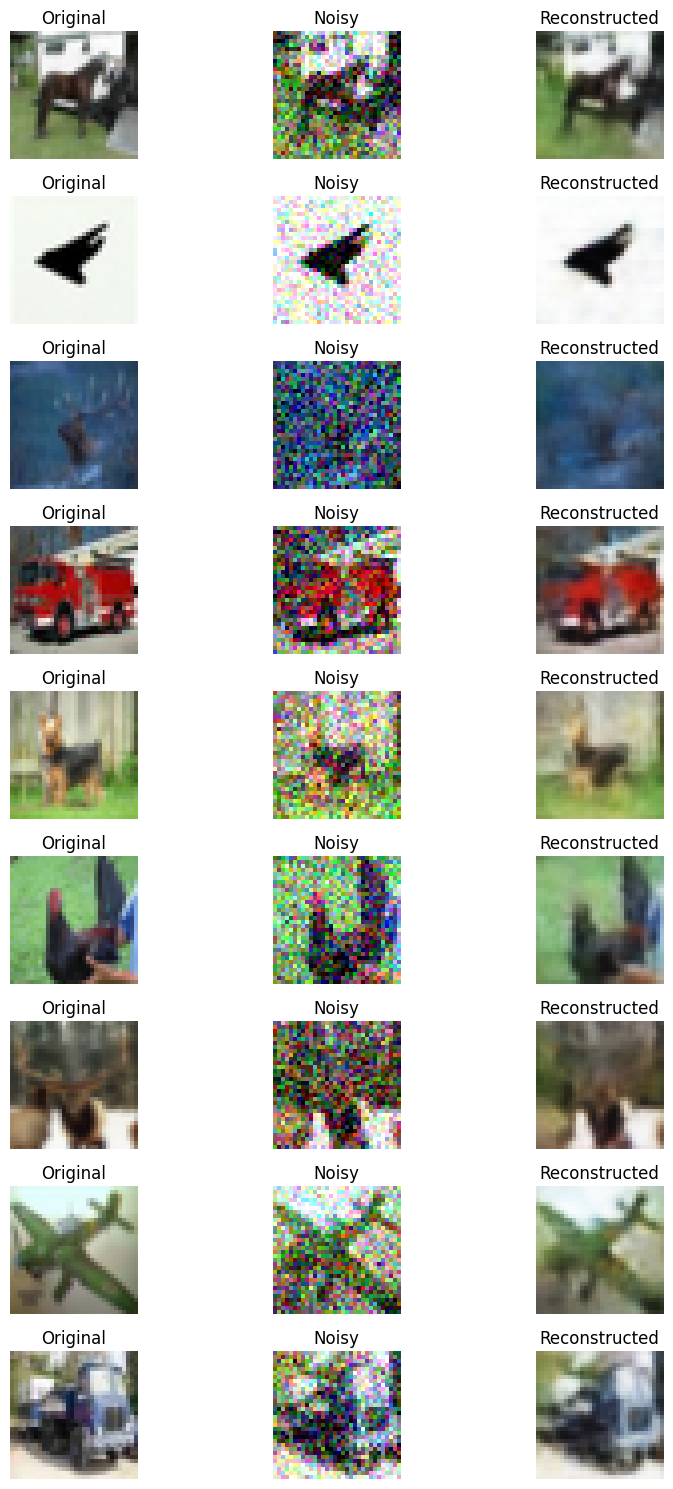

In [7]:
fig, axes = plt.subplots(9, 3, figsize=(9, 15))
for i in range(9):
    axes[i,0].imshow(np.transpose(images[i+20].cpu().numpy(), (1,2,0))); axes[i,0].set_title("Original"); axes[i,0].axis("off")
    axes[i,1].imshow(np.transpose(noisy_images[i+20].cpu().numpy(), (1,2,0))); axes[i,1].set_title("Noisy"); axes[i,1].axis("off")
    axes[i,2].imshow(np.transpose(reconstructions[i+20].cpu().numpy(), (1,2,0))); axes[i,2].set_title("Reconstructed"); axes[i,2].axis("off")
plt.tight_layout()
plt.show()